# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%env CUDA_VISIBLE_DEVICES=0
%env BLISS_HOME=/home/yppatel/bliss

Modules to reload:
all-except-skipped

Modules to skip:

env: CUDA_VISIBLE_DEVICES=0
env: BLISS_HOME=/home/yppatel/bliss


In [10]:
%matplotlib inline 

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch

from bliss.inference import SDSSFrame
from bliss.datasets import sdss
from bliss.inference import reconstruct_scene_at_coordinates
from case_studies.substructure.plots.main import load_models


from astropy.table import Table

import plotly.express as px
import plotly.graph_objects as go

In [4]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

0


# Encoder blend images

In [5]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="config"):
    cfg = compose("config", overrides=[])
    
    
# enc, dec = load_models(cfg, device)
# bp = enc.border_padding
# torch.cuda.empty_cache()


In [6]:
dataset = instantiate(
    cfg.datasets.simulated,
    generate_device="cuda:0",
)

In [7]:
from bliss.catalog import TileCatalog
batch = dataset.get_batch()
tile_catalog = TileCatalog(
    4, {k: v for k, v in batch.items() if k not in {"images", "background", "global"}}
)
full_catalog = tile_catalog.to_full_params()

In [8]:
tile_catalogs = {}
tile_catalogs["main_deflector"] = dataset.image_prior.sample_prior(dataset.tile_slen, dataset.batch_size, dataset.n_tiles_h, dataset.n_tiles_w)
if dataset.substructure_prior:
    tile_catalogs["substructure"] = dataset.substructure_prior.sample_prior(dataset.substructure_tile_slen, dataset.batch_size, dataset.substructure_n_tiles_h, dataset.substructure_n_tiles_w)
full_catalog = tile_catalogs["substructure"].to_full_params()

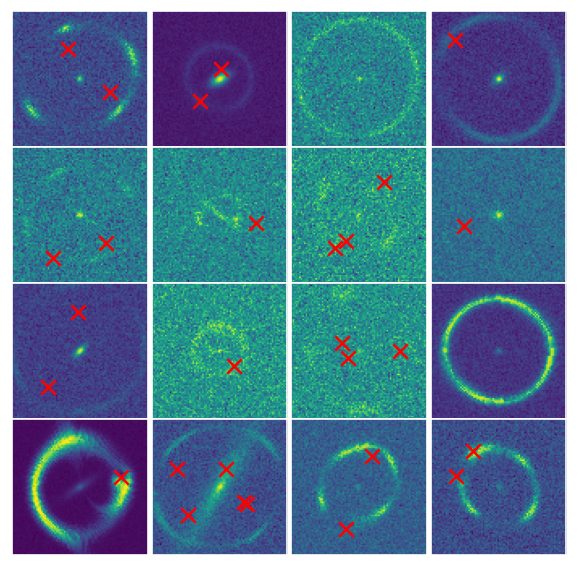

In [11]:
import numpy as np
images, background = dataset.simulate_image_from_catalog(tile_catalogs)
plt.rcParams["axes.grid"] = False
sample_batch_size = 16

fig, axs = plt.subplots(sample_batch_size // 4, 4, figsize=(6, 6), dpi=120)
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(sample_batch_size):
    axs[i // 4, i % 4].imshow(np.log(images[i,0,:,:].cpu() + 2))
    axs[i // 4, i % 4].set_xticklabels([])
    axs[i // 4, i % 4].set_yticklabels([])
    axs[i // 4, i % 4].tick_params(left = False, bottom = False)

    for loc in full_catalog.plocs[i]:
        if loc.any():
            y, x = loc + dataset.image_decoder.border_padding
            axs[i // 4, i % 4].scatter(x, y, marker='x', color='r', s=75)

In [11]:
import numpy as np
images, background = dataset.simulate_image_from_catalog(tile_catalogs)
plt.rcParams["axes.grid"] = False
sample_batch_size = 16

fig, axs = plt.subplots(sample_batch_size // 4, 4, figsize=(6, 6), dpi=120)
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(sample_batch_size):
    axs[i // 4, i % 4].imshow(np.log(images[i,0,:,:].cpu() + 2))
    axs[i // 4, i % 4].set_xticklabels([])
    axs[i // 4, i % 4].set_yticklabels([])
    axs[i // 4, i % 4].tick_params(left = False, bottom = False)

    for loc in full_catalog.plocs[i]:
        if loc.any():
            y, x = loc + dataset.image_decoder.border_padding
            axs[i // 4, i % 4].scatter(x, y, marker='x', color='r', s=75)